#### To do
* Get Intro written with simple 3D image
* Have as much code included in a library as possible
* Get straight to the point
* Then break down the function

### Z-slicing of triangulated surface with tool

One of the fundamental algorithms in 3-axis machining is the Z-slicer 
which is the basis of the "waterline toolpath".  
It is necessary to the paths from each slice before it becomes a toolpath, 
but we will look at this later.

This Z-slicing function takes in a toolshape, a Z-value, and a surface 
to be machined in the form of a set of triangles.  It returns 
a set of 2D contours in the Z-plane which surround the area 
where the tool can move free of any contact with the surface.  
The points on these contours represent the positions where the 
tool is just touching the surface.  


(-26.399999999999999, 26.399999999999999) (-61.350000000000001, 56.350000000000001) (-2.3749791636638613e-15, 74.0) 58.85


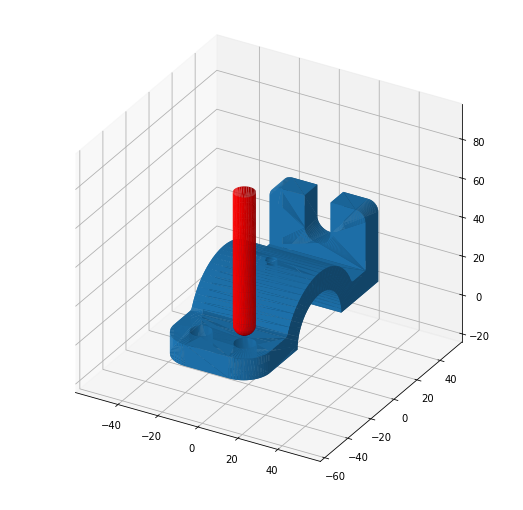

In [1]:
%matplotlib inline

from zslicing_funcs import loadplottriangles, plottoolshape, set_aspect_equal_3d
fname = "stlsamples/frameguide.stl"
tbm = loadplottriangles(fname)
ax = plottoolshape(5, 68, -2, -20, 1)
set_aspect_equal_3d();


which takes a toolshape (aligned with the Z-axis), a 
surface defined as set of triangles, and a horizontal plane, 
and returns a set of contours in the plane enclosing the areas 
where the tool would be in contact (or embedded) in the surface.

**Tool definition**: 
Consider a ball-nosed tool of radius $r$ and tip at point 
$p = (p_x, p_y, p_z)$, 
then the set of points within this tool could be defined as:
$$ T_p = \{q \mid \lvert q-p_{+zr} \rvert \le r \} 
\cup 
\lbrace q \mid 
q_z \ge p_z+r \text{ and }
\lvert q_{xy} - p_{xy} \rvert \le r
\rbrace $$
where
$$p_{xy} = (p_x, p_y, 0), \space p_{+zr} = (p_x, p_y, p_z+r).$$
This is simply the union of a sphere and a cylinder extending 
upward to infinity.  By convention we position the tool according to 
its tip rather than the centre of the ball (although it would be 
more mathematically natural), because it can be directly aligned -- 
you can lower the tip of the tool until it is in contact 
with a flat surface, but you can't do the same with its centre.

**Surface model definition**: 
Most machining algorithms require the model to be approximated 
by a (large) set of triangles.  It is normally well within the
capability of the average computer to hold such an approximation 
to a realistic tolerance within its main memory.  Triangles 
are used because they are well defined, and every CAD model 
that has any sort of visualization is capable of 
outputting them owing to the fact that computer graphics 
depends on it.  The memory available in the average computer 
far outstrips what is realistically demanded in terms 
of machining tolerance.

A triangle $R$ is defined from three points $(p_a, p_b, p_c)$ 
where: 
$$R = \lbrace p_a + \lambda (p_b - p_a) + \mu (p_c - p_a) \mid 
\lambda, \mu \geq 0 \text{ and } \lambda + \mu \leq 1 \rbrace$$
A model $M$ is simply a set of such triangles:
$$M = \lbrace R_i \mid i = 1, \dots, n \rbrace$$ 
Often these triangles share edges and vertices to form a surface 
mesh, but it is not a requirement.

**Tool area of the Z-plane**: 
Given a horizontal plane at height $z$ defined as:
$$H_z = \lbrace (x, y, z) \mid -\infty <x<\infty, -\infty < y < \infty \rbrace$$
then the area of impingement of the tool in this plane is 
simply defined as:
$$ S_{T,M,z} = \lbrace p \in H_z \mid T_p \cap R \neq \emptyset 
\text{ for some } R \in M \rbrace$$
This is a complicated way of saying that we keep all the 
points where the tool occupies the same volume as 
the surface.  The boundary of this area will be the 
set of points where the tool is touching (is in contact with) 
the surface.  When it goes deeper than mere touching, we call 
it "gouging".

It should be obvious that:
$$S_{T,M,z} = \bigcup_{R \in M} S_{T,R,z}$$
where:
$$ S_{T,R,z} = \lbrace p \in H_z \mid T_p \cap R \neq \emptyset 
 \rbrace$$
This is important, because it means we can define 
the functions to calculate $S_{T,R,z}$ based on a single triangle,
and know how to generalize it to an model $M$ composed of a 
set of such triangles.




* Get the single triangle to plot (maybe in 3D) with the toolshape
* Get the tool shaft and ball both working
* Plot in 2D the triangle
* Plot the sample space around the triangles
* Plot a series of radiating lines out from the centre point
* Plot the combined lines between the graph paper arranged nodes
* plot the full on subdividing contour
* Run and plot the values at many slices
* Plot same in 3D (if possible)
* Commit and send to FreeCAD guy
* This fundamental algorithm works for rest area detection, pencil milling, constant scallop.
* I would like to have it sufficiently opened out that we can consider getting it to a form where it can run on a GPU; in which case it will out-perform the commercial systems out there.

In [25]:
from matplotlib import pyplot as plt
from matplotlib import collections  as mc
%matplotlib inline

tbarmesh = TriangleBarMesh(flat9triangles=[[0,0,0, 1,0,1, 0.5,2,2]])


In [41]:
[[(bar.nodeback.p.x, bar.nodefore.p.x), (bar.nodeback.p.y, bar.nodefore.p.y)]  for bar in tbarmesh.bars ]

[[(0.0, 0.5), (0.0, 2.0)], [(0.0, 1.0), (0.0, 0.0)], [(0.5, 1.0), (2.0, 0.0)]]

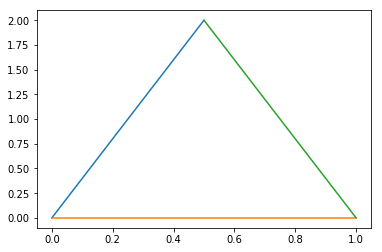

In [42]:
for bar in tbarmesh.bars:
    plt.plot((bar.nodeback.p.x, bar.nodefore.p.x), (bar.nodeback.p.y, bar.nodefore.p.y))


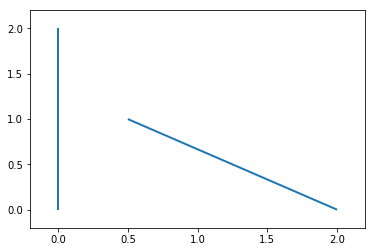

In [40]:
ax = plt.gca()
ax.add_collection(mc.LineCollection([[(bar.nodeback.p.x, bar.nodefore.p.x), (bar.nodeback.p.y, bar.nodefore.p.y)]  for bar in tbarmesh.bars ], linewidths=2))
ax.autoscale()
ax.margins(0.1)

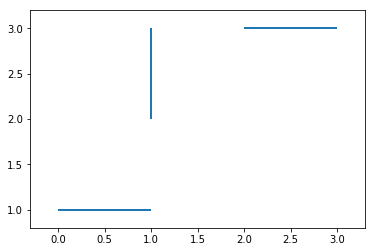

In [31]:


lines = [[(0, 1), (1, 1)], [(2, 3), (3, 3)], [(1, 2), (1, 3)]]

lc = mc.LineCollection(lines, linewidths=2)
ax = plt.gca()
ax.add_collection(lc)
ax.autoscale()
ax.margins(0.1)

In [2]:

# PointZone { izone: {PZ_WITHIN_R, PZ_BEYOND_R}, r, v }

from tool_impingement import spheredistance, cylinderdistance
from tool_impingement.triangleimpingementscanning import ImpingementShape

# these upgrade the pointzone to something specific to the toolshape
def DPZsphere(p, pz, iasphere):
    return spheredistance.DistPZ(p, pz)  
def DLPZsphere(p, vp, r, iasphere):
    return spheredistance.DistLamPZ(p, vp, r)

def DPZcylinder(p, pz, iacylinder):
    return cylinderdistance.DistPZC(p, pz.r, iacylinder.zlo, iacylinder.zhi)
def DLPZcylinder(p, vp, r, iacylinder):
    return cylinderdistance.DistLamPZC(p, vp, r, iacylinder.zlo, iacylinder.zhi)


class ImpingementSphere(ImpingementShape):
    def __init__(self, tbarmesh, tboxing, r):
        super().__init__(tbarmesh, tboxing, DPZsphere, DLPZsphere)
        
    def Isb2dcontournormals(self):
        return False
        
class ImpingementCylinder(ImpingementShape):
    def __init__(self, tbarmesh, tboxing, r, zlo, zhi):
        super().__init__(tbarmesh, tboxing, DPZcylinder, DLPZcylinder)
        assert zlo <= zhi
        self.zlo = zlo
        self.zhi = zhi
        
    def Isb2dcontournormals(self):
        return False




In [3]:
from tribarmes import TriangleBarMesh, SingleBoxedTriangles
tbarmesh = TriangleBarMesh(flat9triangles=[[0,0,0, 1,0,1, 0.5,2,2]])
tboxing = SingleBoxedTriangles(tbarmesh)


In [4]:
tboxing.CloseBoxeGenerator(0,0,0,0,0)

[0]

In [5]:
from barmesh import PointZone
from basicgeo import P3
sphrad = 0.5
ia = ImpingementSphere(tbarmesh, tboxing, sphrad)
pz = PointZone(0, 10, None)
p = P3(0.1, 0.1, 0.3)
ia.DistP(pz, p)
pz.r

0.07808688094430301

0.6569296691827246
0.8132268424744065
0.24609470320893184
0.9960947032089313
0.49609470320893345
0.7573593128807135
0.7460947032089331
0.34314575050761587
0.2460947032089324
0.9960947032089318
0.5192593015921352
0.0717967697244859
0.07179676972448412
0.5192593015921316
0.9289321881345209


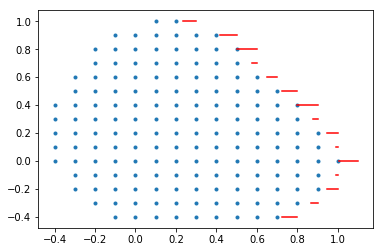

In [23]:
from matplotlib import pyplot as plt
%matplotlib inline

import numpy
xs = numpy.arange(-1, 2, 0.1)
ys = numpy.arange(-1, 2, 0.1)
kxs, kys = [ ], [ ]
zslice = 0.3
kpts = [ ]
for x in xs:
    kpts.append([])
    for y in ys:
        pz = PointZone(0, 10, None)
        p = P3(x, y, 0.3)
        ia.DistP(pz, p)
        kpts[-1].append((p, pz))
        
kxs, kys = [ ], [ ]
for kx in kpts:
    for ky in kx:
        if ky[1].r < sphrad:
            kxs.append(ky[0].x)
            kys.append(ky[0].y)
plt.scatter(kxs, kys, marker=".")            

from basicgeo import Along
kxs, kys = [ ], [ ]
for i in range(1, len(kpts)):
    for j in range(1, len(kpts[i])):
        if kpts[i][j][1].r > sphrad and kpts[i-1][j][1].r < sphrad:
            pout, pin = kpts[i][j][0], kpts[i-1][j][0]
            lam = ia.Cutpos(pout, pin - pout, None, sphrad)
            plt.plot([pout.x, Along(lam, pout.x, pin.x)], [pout.y, Along(lam, pout.y, pin.y)], color="red")
            print(lam)

#    p = P3(0.1, 0.1, 0.3)
#x.DistP(pz, p)
#pz.r

